<a href="https://colab.research.google.com/github/renata-cruz/GSoC/blob/main/GSoC_DisimpyWM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install disimpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.1 MB/s 
  Created wheel for disimpy: filename=disimpy-0.2.1-py3-none-any.whl size=1546139 sha256=c76a42375ace7946c68c3e68f886e7eb21d0f0cffe471ad0825bc470e9833906
  Stored in directory: /root/.cache/pip/wheels/80/b5/4b/e40dfa23d4bf354720976e6bff8eb4ccf4059119ead0c28ac9
Successfully built disimpy


In [ ]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import norm
from disimpy import substrates

## 1. Are These Circles Overlapping?

Write a function that checks if two circles with radii r_1, r_2 and centers (x_1, y_1), (x_2, y_2) overlap.

Solution: d > r1 + r2

In [90]:
def non_overlapping_circles(C1, r1, C2, r2):
  """Check if two circles overlap.
  
  Parameters
  ----------
  r1: float
      Radius of the circle 1.
  r2: float
       Radius of the circle 2.
  C1: tuple
      Center of circle 1 C1(x1, y1). 
  C2: tuple
      Center of circle 2 C2(x2, y2).

  Returns
  -------
  boolean
  """
  x1, y1 = C1
  x2, y2 = C2
  if np.sqrt((y2-y1)**2 + (x1-x2)**2) <= (r1 + r2):  
    return False
  return True

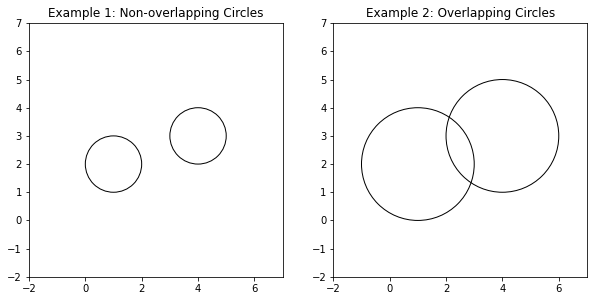

In [92]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

radii = [1, 2]
titles=['Example 1: Non-overlapping Circles', 'Example 2: Overlapping Circles']
    
for ax, ri, title in zip(axs.flat, radii, titles):
  c1 = plt.Circle((1, 2), ri, fill=False) 
  c2 = plt.Circle((4, 3), ri, fill=False)

  ax.set_aspect(1) 
  ax.add_artist(c1) 
  ax.add_artist(c2) 

  ax.set_xlim([-2, 7])
  ax.set_ylim([-2, 7])
  ax.set_title(title)     

plt.show()

In [94]:
test_no = non_overlapping_circles((1, 2), 1, (4, 3), 1)
test_o = non_overlapping_circles((1, 2), 2, (4, 3), 2)

print('Non-overlapping circles')
print('Example 1:', test_no)
print('Example 2:', test_o)

Non-overlapping circles
Example 1: True
Example 2: False


## 2. Place Circles in a Square

Draw N numbers from a gamma distribution with given parameters. Sort the numbers from largest to smallest. For each number, draw a random position within a square (simulated voxel size) and check if it overlaps with any placed circles. Repeat position sampling until no overlap. Add periodic boundaries.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Gamma Distribution')]

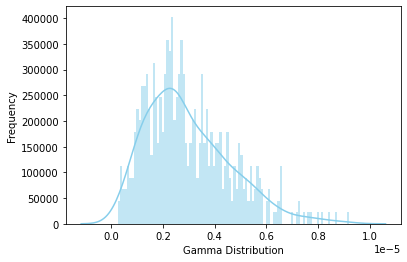

In [95]:
n = int(5e2)
k = 3
theta = 1e-6

sampled_radii = np.random.gamma(k, theta, n) 

ax = sns.distplot(sampled_radii,
                  kde=True,
                  bins=100,
                  color='skyblue',
                  hist_kws={"linewidth":15,'alpha':.5})

ax.set(xlabel='Gamma Distribution', ylabel='Frequency')

In [ ]:
def mirrored_circles(C, r, voxel_size):
  '''
  Create mirrored versions of a circle.
  
  Parameters
  ----------
  C: tuple
      Center of circle C(x, y).
  r: float
      Radius of the circle. 
  voxel_size: float
      Size of the voxel.

  Returns
  -------
  mirrors: numpy.ndarray
      Array with center coordinates for the mirrors.
  '''
  x, y = C
  mirrors = [[x, y, r],
            [x - voxel_size, y, r],
            [x + voxel_size, y, r],
            [x, y - voxel_size, r],
            [x, y + voxel_size, r],
            [x - voxel_size, y - voxel_size, r],
            [x + voxel_size, y - voxel_size, r], 
            [x - voxel_size, y + voxel_size, r],
            [x + voxel_size, y + voxel_size, r]]
  return mirrors

In [ ]:
def sampling_circles(n_objects, shape, scale, voxel_size):
  '''
  Sample circles from a gamma distribution and packed them in a voxel with periodic boundaries.
  
  Parameters
  ----------
  n_objects: int
      Number of circles to be sampled.
  shape: float
      The shape of the gamma distribution.
  scale: float
      The scale of the gamma distribution. 
  voxel_size: float
      Size of the voxel.

  Returns
  -------
  placed_circles: numpy.ndarray
      Array with the center coordinates and radius of the cirlces placed in the voxel.
  placed_mirrors: numpy.ndarray
      Array with the center coordinates and radius of the cirlces placed in the voxel and their mirrors.
  '''
  sampled_radii = np.random.gamma(shape, scale, n)
  sampled_radii = np.sort(sampled_radii)[::-1]
  placed_circles = np.zeros((n, 3))
  placed_mirrors = np.zeros((n*9, 3))
  filled_positions = 1
  for r in sampled_radii:
      placed = False
      i = 0
      while not placed and i < 1e2: 
        i += 1
        x, y = np.random.random(2) * voxel_size
        mirrors = mirrored_circles((x, y), r, voxel_size)
        if np.all(placed_circles == 0):
          placed_circles[0] = x, y, r
          for mirror, k in zip(mirrors, range(len(mirrors))):
            placed_mirrors[k] = mirror
          placed = True
        else:
          intersects = False
          for mirror_cand in mirrors:
            m_x, m_y, r = mirror_cand
            end = filled_positions * 9
            for mirror_stored in placed_mirrors[:end]:
              ms_x, ms_y, ms_r = mirror_stored
              if not non_overlapping_circles((m_x, m_y), r, (ms_x, ms_y), ms_r):
                intersects = True 
                break
          if not intersects:
            placed_circles[filled_positions] = x, y, r
            interval = filled_positions * 9
            for mirror, k in zip(mirrors, range(interval, len(mirrors)+interval)):
              placed_mirrors[k] = mirror
            placed = True
            filled_positions += 1      
  return placed_circles, placed_mirrors

In [ ]:
n = int(5e2)
shape = 3
scale = 1e-6
voxel_size = 1e-4

circles, mirrors = sampling_circles(n, shape, scale, voxel_size)

(500, 3) (4500, 3)


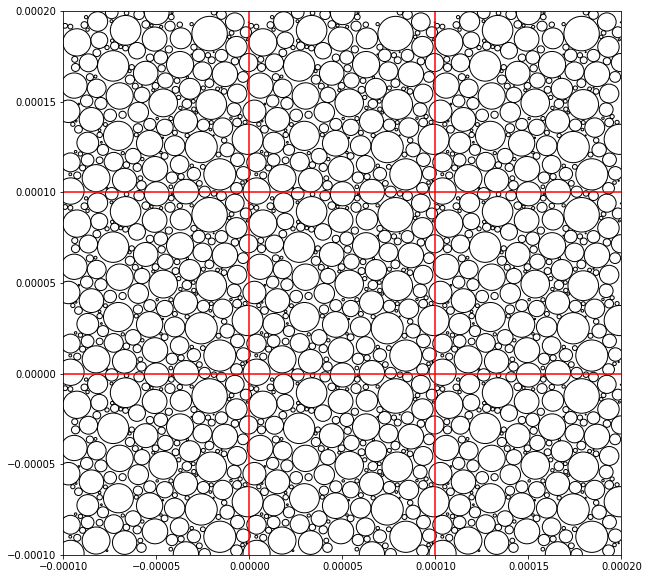

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
for mirror in mirrors:
  circle = plt.Circle((mirror[0], mirror[1]), mirror[2], fill=False)
  ax.add_artist(circle)
ax.set_xlim([-1e-4, 2e-4])
ax.set_ylim([-1e-4, 2e-4])
plt.axvline(x = 0, color = 'r')
plt.axvline(x = 1e-4, color = 'r')
plt.axhline(y = 0, color = 'r')
plt.axhline(y = 1e-4, color = 'r')
plt.show()

## 3. Create Cylindric Substrates

Write a function for creating a triangular mesh representing a cylinder and save the vertices and faces using the Disimpy function.

In [ ]:
def cylinder_mesh(r, C, n_faces, h):
  '''
  Generate a cylindric mesh.
  
  Parameters
  ----------
  r: float
      Radius of the circle. 
  C: tuple
      Center of circle C(x, y).
  n_faces: int
      Number of faces for the mesh.
  h: int
      Hight of the cylinder.

  Returns
  -------
  vertices: numpy.ndarray
      Array of vertices for the mesh.
  faces: numpy.ndarray
      Array of faces for the mesh.
  '''
  vertices = []
  faces = []
  thetas = np.linspace(0, 2*np.pi, n+1)
  for theta in thetas:
    v_base = [r * np.sin(theta) + c[0], r * np.cos(theta) + c[1], 0]
    v_h = [r * np.sin(theta) + c[0], r * np.cos(theta) + c[1], h]
    vertices.append(v_base)
    vertices.append(v_h)
  indexes = range(len(vertices)-2)
  for i in indexes:
    t = [i, i+1, i+2]
    faces.append(t)
  connection_points = [[len(vertices)-1, len(vertices)-2, 1],[len(vertices)-2, 0, 1]]
  for p in connection_points:
    faces.append(p)
  return np.array(vertices), np.array(faces)

In [ ]:
vertices, faces = cylinder_mesh(1e-6, (0, 0), 100, 10e-6)

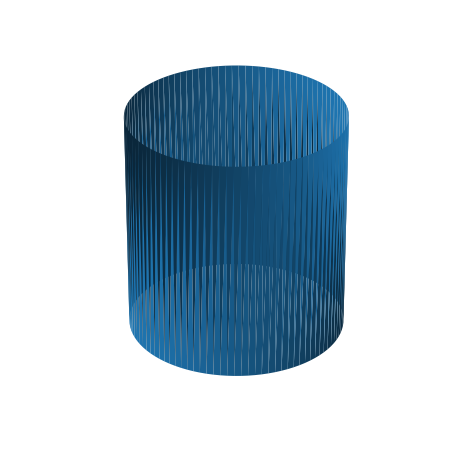

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_trisurf(
    vertices[:, 0],
    vertices[:, 1],
    vertices[:, 2],
    triangles=faces,
)
plt.axis("off")
plt.show()

In [ ]:
n = [5, 10, 50, 100, 500]

for i in n: 
  %timeit cylinder_mesh(1e-6, (0, 0), i, 10e-6)

The slowest run took 4.14 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 130 µs per loop
10000 loops, best of 5: 193 µs per loop
1000 loops, best of 5: 586 µs per loop
1000 loops, best of 5: 1.14 ms per loop
100 loops, best of 5: 5.45 ms per loop


## 4. Creating Packed Cylinders

Create a function to pack cylinders in a voxel with periodic boundaries.

In [85]:
def packed_cylinders(n_objects, voxel_size, shape, scale, n_faces, h):
  '''
  Create a voxel of packed cylindric meshed with gamma distributed radii.
  
  Parameters
  ----------
  n_objects: int
      Number of cylinders to be sampled.
  voxel_size: float
      Size of the voxel.
  shape: float
      The shape of the gamma distribution.
  scale: float
      The scale of the gamma distribution.
  n_faces: int
      Number of faces for the mesh.
  h: int
      Hight of the cylinders.

  Returns
  -------
  vertices: numpy.ndarray
      Array of vertices for the mesh.
  faces: numpy.ndarray
      Array of faces for the mesh.
  '''
  circles = sampling_circles(n_objects, shape, scale, voxel_size)[0] 
  faces = []
  vertices = []
  for base in circles:
    x, y, r = base[0], base[1], base[2]
    v, f = cylinder_mesh(r, (x,y), n_faces, h)
    faces.append(f)
    vertices.append(v)
  return np.asarray(vertices), np.asarray(faces)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [88]:
vertices, faces = packed_cylinders(n_objects = int(5e2), voxel_size = 1e-4,shape = 3, scale = 1e-6, n_faces = 50, h = 10e-6)

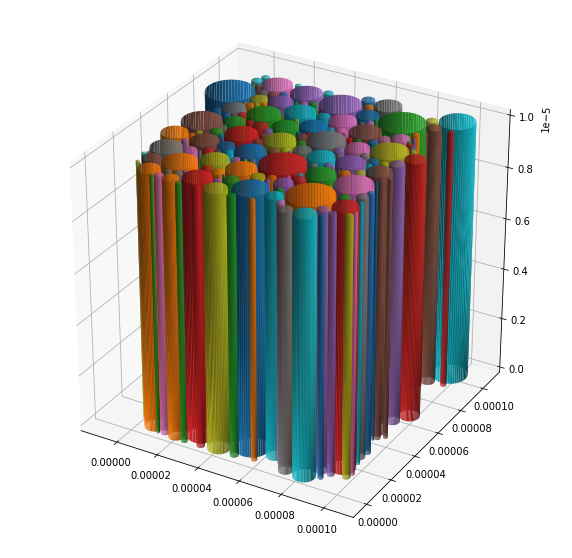

In [89]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
for i in range(faces.shape[0]): 
  ax.plot_trisurf(
      vertices[i][:, 0],
      vertices[i][:, 1],
      vertices[i][:, 2],
      triangles=faces[i],
  )
fig.show()

### Adding Partial Cylinders in the Borders